#Imports/Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


#Data import
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

!pip install yfinance --upgrade --no-cache-dir
yf.pdr_override()

#For mounting to drive
from google.colab import drive


#Modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

#Modeling Metrics
from sklearn import metrics


Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


In [2]:

#Mount folder to save and retrieve outputs
drive.mount('/content/drive',force_remount=True) 
%cd "/content/drive/My Drive/wk2" 

# you must create the same director or change the reference for this to work

Mounted at /content/drive
/content/drive/My Drive/wk2


#Import price data

In [3]:

hist_prc = pdr.get_data_yahoo("NVDA", start="1999-01-01").reset_index() #imports share price data for NVIDA since 1999

hist_prc.to_csv('output/NVDA.CSV',index=False) #saves as csv to drive




[*********************100%***********************]  1 of 1 downloaded


In [4]:
hist_prc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5.197000e+03
mean,37.776541,38.394368,37.107122,37.763362,36.881512,1.604057e+07
std,60.663243,61.502547,59.691795,60.615441,60.628347,1.162357e+07
min,1.395833,1.421875,1.333333,1.364583,1.258858,4.920000e+05
25%,9.197917,9.463333,8.973333,9.250000,8.533325,8.842000e+06
50%,14.683333,14.950000,14.460000,14.700000,13.616420,1.344540e+07
75%,22.850000,23.299999,22.469999,22.893333,21.651581,1.977060e+07
max,289.320007,292.760010,285.579987,289.359985,288.443909,2.307714e+08


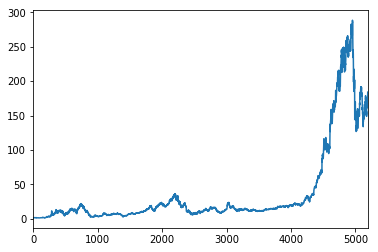

In [5]:

hist_prc["Adj Close"].plot()

# Data Preproccessing


In [0]:
hist_prc.set_index("Date", inplace=True)

In [0]:
window_size=28 # sets the number od historic days to predict from
predicted_days = 7 # sets the number of future days to predict
num_samples=len(hist_prc)-window_size

# Get indices of access for the data
indices=np.arange(num_samples).astype(np.int)[:,None]+np.arange(window_size-predicted_days).astype(np.int)
yindices= np.arange(num_samples).astype(np.int)[:,None]+np.arange(window_size-predicted_days,window_size).astype(np.int)
dindices=np.arange(1).astype(np.int)[:,None]+np.arange(num_samples,num_samples + window_size-predicted_days).astype(np.int)

x = hist_prc['Adj Close'].values[indices]
y = hist_prc['Adj Close'].values[yindices]
deploy = hist_prc['Adj Close'].values[dindices]





In [0]:
split_fraction=0.8 #training/test data split (80/20)
ind_split=int(split_fraction*num_samples)

In [0]:
x_train = x[:ind_split]
y_train = y[:ind_split]
x_test = x[ind_split:]
y_test = y[ind_split:]

#Modeling

In [0]:
#Help Functions
def get_performance (model_pred):
  #Function returns standard performance metrics
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, model_pred).round(4))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, model_pred).round(4))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, model_pred)).round(4))
  
  
  
def get_plot (model_pred):
  plt.scatter(model_pred, y_test, color="blue")
  plt.plot(y_test, y_test, color='red', linewidth=2)

## "Previous Day" Baseline

In [0]:
y_pred_lag=np.roll(y_test,1)

In [12]:
get_performance(y_pred_lag)

Mean Absolute Error: 3.1404
Mean Squared Error: 32.2277
Root Mean Squared Error: 5.6769


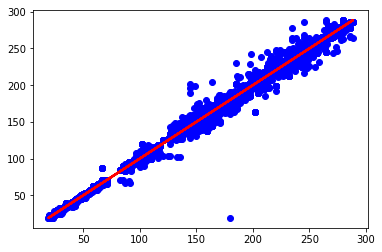

In [13]:
get_plot(y_pred_lag)

## Linear Regression

In [0]:
# Train
model_lr=LinearRegression() # initialise linear regression model
model_lr.fit(x_train, y_train) 

# Infer

y_pred_lr=model_lr.predict(x_test)
y_pred_d=model_lr.predict(x_test)

In [15]:
get_performance(y_pred_lr)

Mean Absolute Error: 5.5812
Mean Squared Error: 75.2239
Root Mean Squared Error: 8.6732


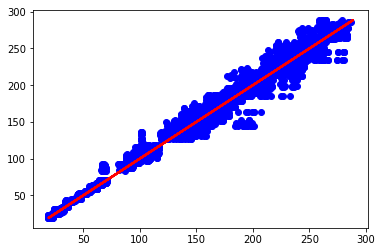

In [16]:
get_plot(y_pred_lr)

## Method #1- Ridge Regression

In [17]:
#Train
model_ridge = Ridge()
model_ridge.fit(x_train, y_train)

#Infer
y_pred_train_ridge = model_ridge.predict(x_train)
y_pred_ridge=model_ridge.predict(x_test)
y_pred_ridge_d=model_ridge.predict(deploy)
deploy.shape

(1, 21)

## Plot Predicted Days Against Historic Days

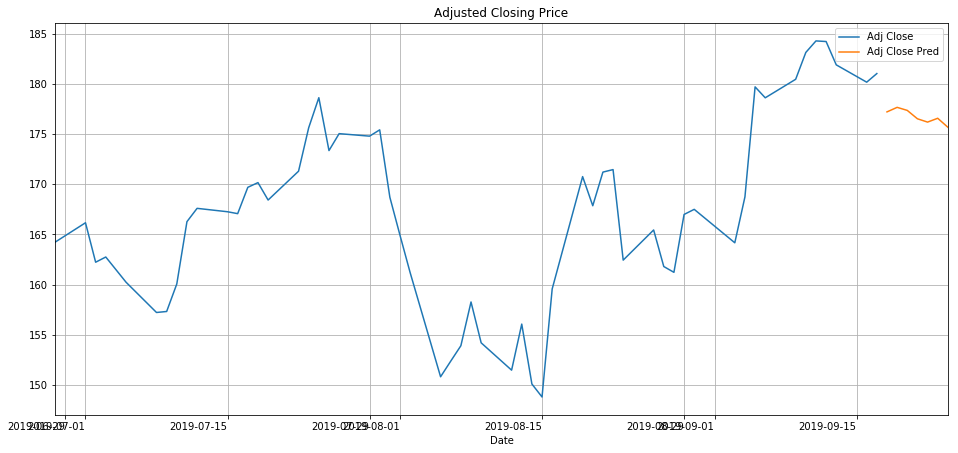

In [24]:
# Create flattened array of future dates to predict for plotting
def ftrdate(days_from_today):
  ftrday = []
  for x in range(days_from_today):
    ftrday.append(datetime.date.today() + datetime.timedelta(x + 1))
  return np.ndarray.flatten(np.array(ftrday))

# Plot predicted days 
df_ridge = hist_prc.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[num_samples-window_size:] 

indx=pd.Index(ftrdate(predicted_days))
y_pred_ridge_d = np.ndarray.flatten(y_pred_ridge_d)
df_ridge_pred = pd.DataFrame(data=y_pred_ridge_d,index=indx,columns=['Adj Close Pred']) 

ax=df_ridge.plot(label='NVDA', figsize=(16,8), title='Adjusted Closing Price', grid=True)
df_ridge_pred.plot(label='NVDA', figsize=(16,8), title='Adjusted Closing Price', grid=True, ax=ax)
  

In [19]:
get_performance(y_pred_ridge)

Mean Absolute Error: 5.5815
Mean Squared Error: 75.2271
Root Mean Squared Error: 8.6734


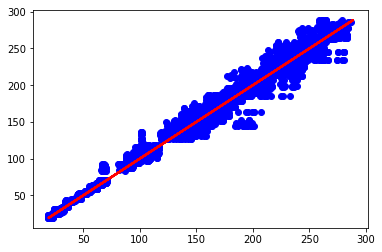

In [20]:
get_plot(y_pred_ridge)

## Lasso

In [0]:
# Model #2 - Lasso
model_la = Lasso(alpha=0.1)
model_la.fit(x_train, y_train)

# Infer
y_pred_la = model_la.predict(x_test)

In [22]:
get_performance(y_pred_la)

Mean Absolute Error: 5.6711
Mean Squared Error: 76.9793
Root Mean Squared Error: 8.7738


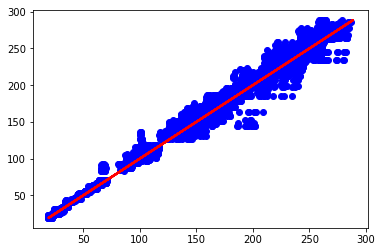

In [23]:
get_plot(y_pred_la)